# Poisson-Zero Hidden Markov Model with Time-Varying Transitions

## Summary

The following exposition uses [`pymc3-hmm`](https://github.com/AmpersandTV/pymc3-hmm) to simulate and estimate a hidden Markov model (HMM) with a time-varying transition matrix and emissions consisting of a Poisson random variable and the point at zero.

In [1]:
import numpy as np
import pandas as pd

import patsy

import theano.tensor as tt

import pymc3 as pm

from pymc3_hmm.utils import multilogit_inv
from pymc3_hmm.distributions import SwitchingProcess, HMMStateSeq
from pymc3_hmm.step_methods import FFBSStep, TransMatConjugateStep

## Introduction

Our observation model can be described as follows:

\begin{align}
  \label{eq:pois-zero-model}
  Y_t &= S_t \epsilon_t,\quad
  \epsilon_t \sim \operatorname{Pois}\left( \mu \right)
  \\
  S_t &\sim \operatorname{Bern}\left( \pi_t \right)
  \;,
\end{align}
where $y_t \sim Y_t$ are the observed values sampled from the observation distribution, $Y_t$, spanning $t \in \left\{0, \dots, T \right\}$.

The "hidden" state sequence, $\{S_t\}$, is driven by the following Markov relationship:

\begin{equation*}
    \operatorname{P}\left(S_t \mid S_{t-1}\right) \triangleq \Gamma_{t,t-1} \in \mathbb{R}^{2 \times 2}_{[0, 1]}
\end{equation*}

The marginal state probability, $\pi_t$, is then given by

\begin{equation*}
  \begin{aligned}
    \operatorname{P}\left( S_t \right)
    &= \int_{S_{t-1}} \operatorname{P}\left(S_t \mid S_{t-1}\right)
    \operatorname{dP}\left(S_{t-1}\right)
    \\
    &=
    \begin{pmatrix}
      \Gamma^{(0, 0)}_{t,t-1} & \Gamma^{(0, 1)}_{t,t-1}
      \\
      \Gamma^{(1, 0)}_{t,t-1} & \Gamma^{(1, 1)}_{t,t-1}
    \end{pmatrix}^\top
    \begin{pmatrix}
      \pi_{t-1}
      \\
      1 - \pi_{t-1}
    \end{pmatrix}
    \\
    &=
      \begin{pmatrix}
      \pi_{t}
      \\
      1 - \pi_{t}
    \end{pmatrix}
  \;.
  \end{aligned}
\end{equation*}

In this example, the rows of our transition matrix, $\Gamma^{(r)}_{t, t-1}$ for $r \in \{0, 1\}$, are driven by a logistic regression:

\begin{gather*}
  \Gamma^{(r)}_{t, t-1} = \operatorname{logit^{-1}}\left( X_t \xi_r \right)
\end{gather*}

where $X_t \in \mathbb{R}^{T \times N}$ is a covariate matrix and $\xi_r \in \mathbb{R}^N$ is the regression parameter vector for row $r$.

In the remainder of this exposition, we will assume normal priors for each $\xi_r$, the conjugate Gamma prior for $\mu$, and a Dirichlet prior for $\pi_0$.

## Simulation

For these simulations, we will generate a time series and make the $\xi_r$ regression consist of fixed-effects for a seasonal component based on weekdays.  In other words, the transition probabilities will vary based on the day of week.

In [2]:
def create_poisson_zero_hmm_tv(mu, xis, pi_0, observed):
    
    z_tt = tt.tensordot(X_df.values, xis, axes=((1,), (0,)))

    P_tt = multilogit_inv(z_tt)

    P_rv = pm.Deterministic("P_t", P_tt)

    S_rv = HMMStateSeq("S_t", P_rv, pi_0, shape=np.shape(observed)[-1])

    Y_rv = SwitchingProcess(
        "Y_t", [pm.Constant.dist(0), pm.Poisson.dist(mu)], S_rv, observed=observed
    )
    return Y_rv


In [12]:
np.random.seed(2032)

start_date = pd.Timestamp("2020-01-01 00:00:00")
time_index = pd.date_range(
    start=start_date, end=start_date + pd.Timedelta("30W"), closed="left", freq="1h"
)
X_ind_df = pd.DataFrame(
    {
        "weekday": time_index.weekday,
    },
    index=time_index,
)

formula_str = "~ 1 + C(weekday)"
X_df = patsy.dmatrix(formula_str, X_ind_df, return_type="dataframe")

xi_0_true = pd.Series(
    # The coefficients used to compute the state zero-to-zero transition probabilities
    np.array([2.0, -5.0, -3.0, 0.0, 0.0, -5.0, -5.0]),
    index=X_df.columns,
)

xi_1_true = pd.Series(
    # The coefficients for the state one-to-zero transition probabilities
    np.array([-2.0, -1.0, 3.0, 0.0, 0.0, 5.0, 5.0]),
    index=X_df.columns,
)

xis_true = tt.as_tensor(np.stack([xi_0_true, xi_1_true], axis=1)[..., None], name="xis")

mu_true = 50
p_0_true = tt.as_tensor(np.r_[0.0, 1.0])

with pm.Model(theano_config={"compute_test_value": "ignore"}) as sim_model:
    _ = create_poisson_zero_hmm_tv(mu_true, xis_true, p_0_true, np.zeros(X_df.shape[0]))

sim_point = pm.sample_prior_predictive(samples=1, model=sim_model)
sim_point["Y_t"] = sim_point["Y_t"].squeeze()

y_t = sim_point["Y_t"]

## Estimation

We will use the "true" data-generating observation model to estimate the parameters $\mu$ and $\Gamma_{t, t-1}$ (the latter as rows denoted by `p_0` and `p_1`).  For demonstration purposes, we choose hyper-parameters for the $\mu$ prior that are "far" from the true $\mu$ value.

The sampling steps for $S_t$ are performed using forward-filtering backward-sampling (FFBS).  The steps for $\Gamma_{t, t-1}$ are conjugate samples conditional on the sampled state sequence $\{S_t\}$ provided by FFBS.  Both of these step methods are available in `pymc3-hmm`.

While $\mu$ could also be sampled exactly using a conjugate step&mdash;conditional on $\{S_t\}$&mdash;we instead sample this parameter using PyMC3's built-in NUTS.

In [13]:
import theano


theano.config.allow_gc = False

with pm.Model(theano_config={"compute_test_value": "ignore"}) as test_model:
    E_mu, Var_mu = 1000.0, 10000.0
    mu_rv = pm.Gamma("mu", E_mu ** 2 / Var_mu, E_mu / Var_mu)

    p_0_rv = pm.Dirichlet("p_0", np.r_[1, 1])

    xis_rv = pm.Normal("xis", 0, 100, shape=(X_df.shape[1], 2, 1))

    _ = create_poisson_zero_hmm_tv(1 + mu_rv, xis_rv, p_0_rv, y_t)

with test_model:
    states_step = FFBSStep([test_model.S_t])
    mu_step = pm.NUTS([test_model.mu, test_model.xis, test_model.p_0])

    posterior_trace = pm.sample(
        step=[states_step, mu_step],
        return_inferencedata=True,
        chains=1,
        progressbar=True,
    )


Sequential sampling (1 chains in 1 job)
CompoundStep
>FFBSStep: [S_t]
>NUTS: [p_0, xis, mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1551 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


## Posterior Samples

/home/bwillard/apps/anaconda3/envs/pymc3-hmm/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


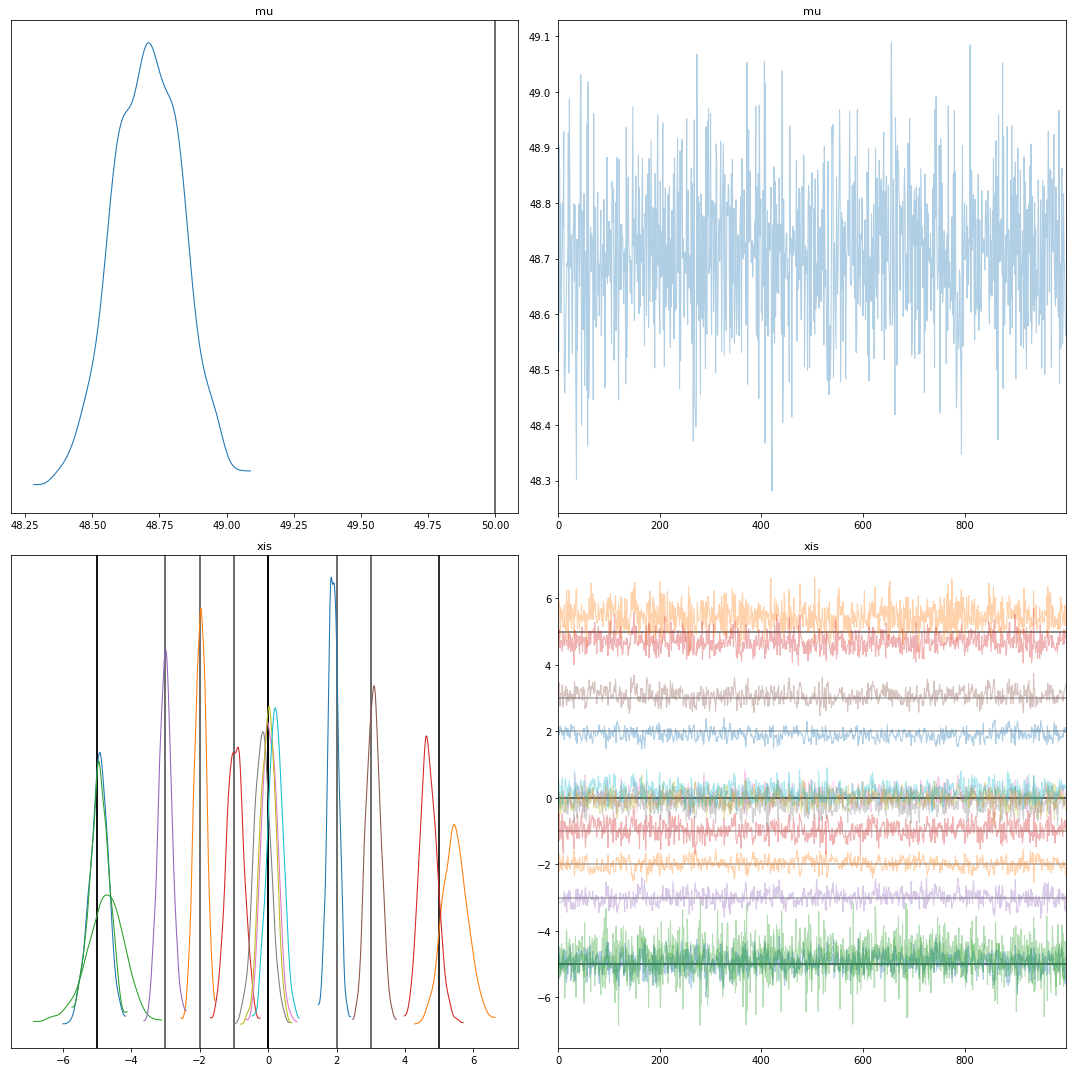

In [14]:
import matplotlib.pyplot as plt


ax = pm.traceplot(
    posterior_trace.posterior,
    var_names=[
        "mu",
        "xis",
    ],
    lines=[
        ("mu", {}, [mu_true]),
        ("xis", {}, [xis_true.data]),
    ],
    compact=True,
    figsize=(15, 15),
)

plt.tight_layout()

## Posterior Predictive Samples

In [15]:
with test_model:
    posterior_pred_trace = pm.sample_posterior_predictive(
        posterior_trace.posterior, var_names=["Y_t"]
    )

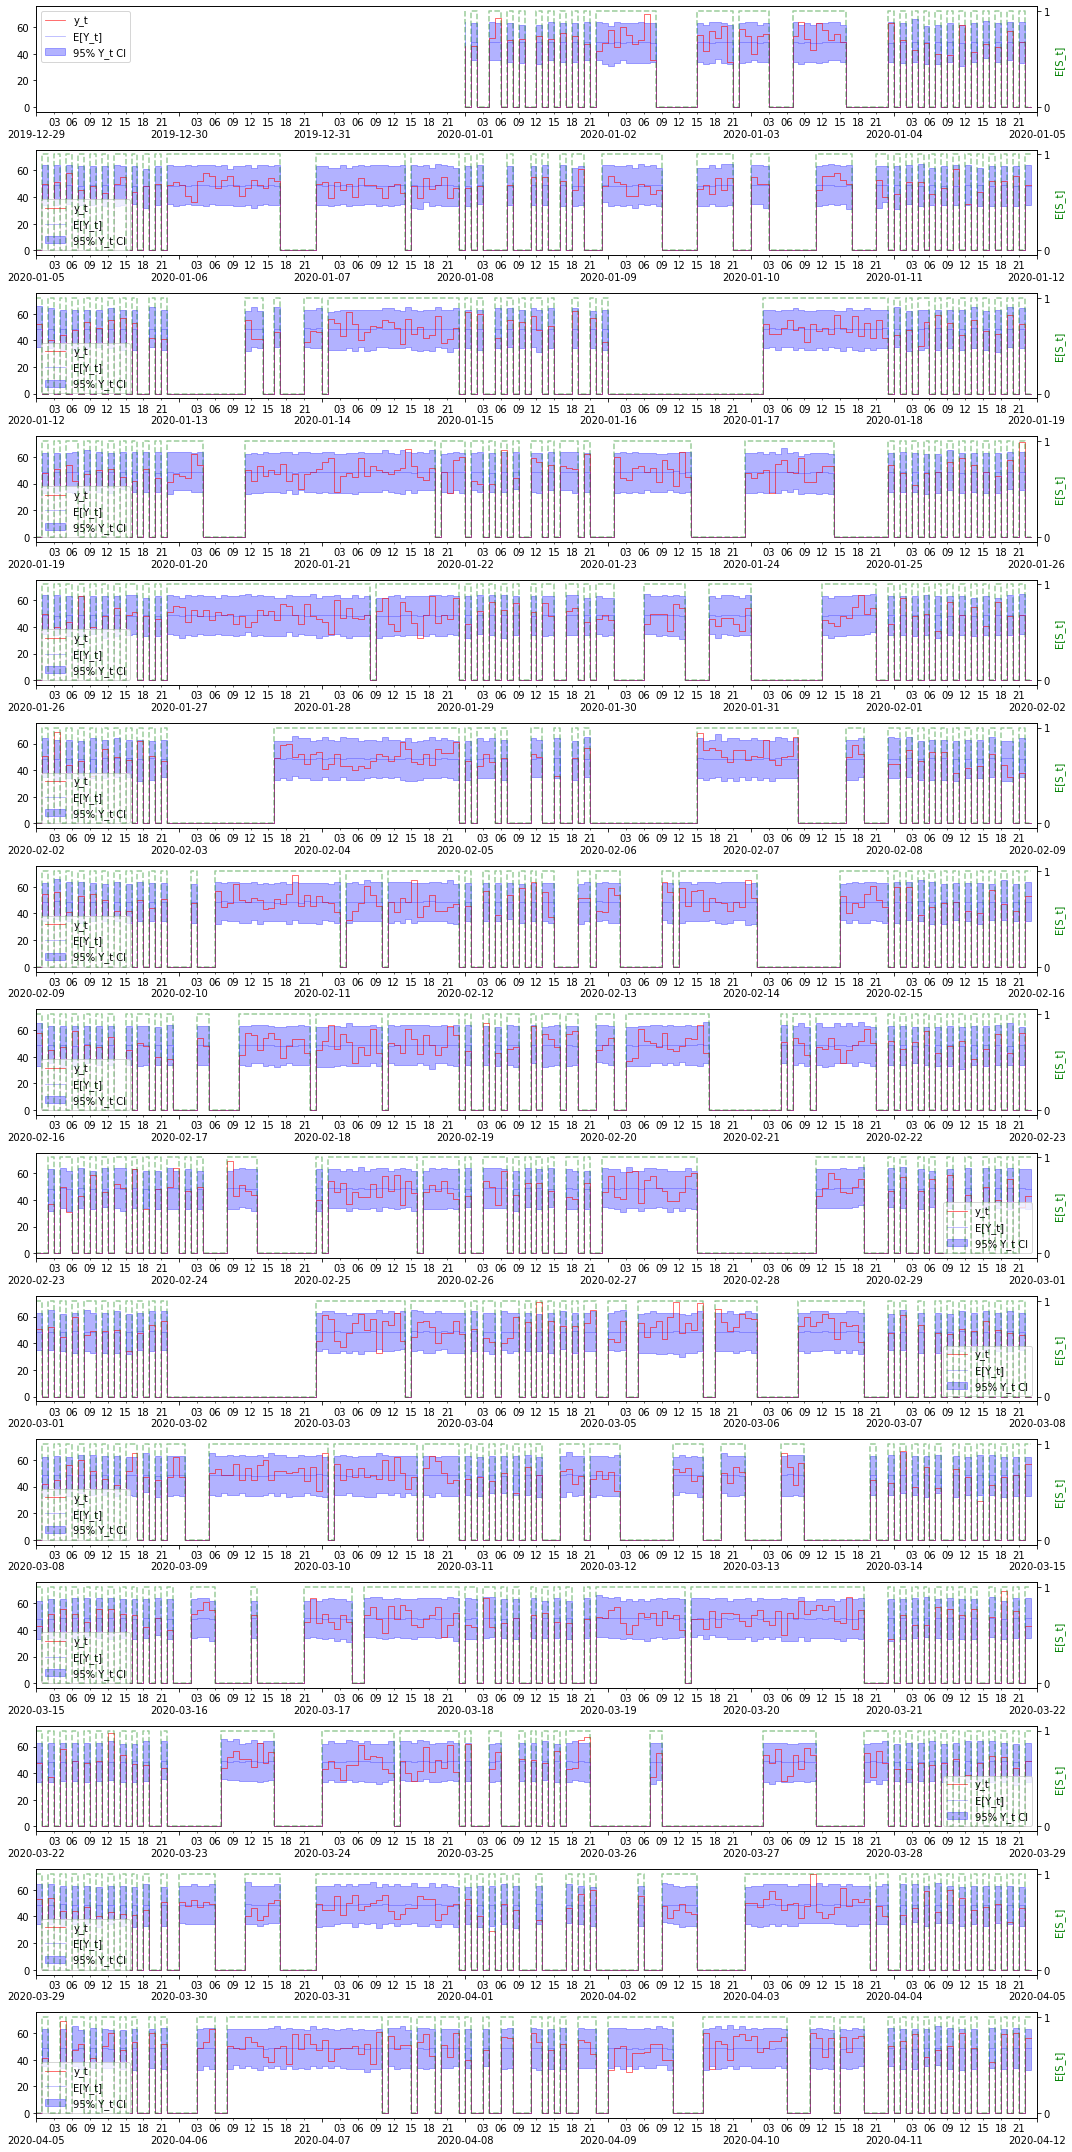

In [18]:
import pandas as pd

import arviz as az

from matplotlib.ticker import MaxNLocator

from pymc3_hmm.utils import plot_split_timeseries


plot_data = pd.DataFrame(
    {"y_t": y_t}, index=time_index
)

with test_model:
    az_post_trace = az.from_pymc3(
        posterior_predictive=posterior_pred_trace,
        dims={"Y_t": ["dt"]},
        coords={"dt": plot_data.index},
    )

hdi_data = az.hdi(
    az_post_trace, hdi_prob=0.97, group="posterior_predictive", var_names=["Y_t"]
).to_dataframe()
hdi_data = hdi_data.unstack(level="hdi")

plot_data["E[Y_t]"] = az_post_trace.posterior_predictive["Y_t"].mean(axis=1).squeeze()
plot_data["E[S_t]"] = posterior_trace.posterior.S_t.mean(axis=1).squeeze()

plot_data = plot_data.merge(hdi_data, right_index=True, left_index=True)


def plot_fn(ax, data, **kwargs):
    ax.plot(
        data["y_t"],
        label="y_t",
        alpha=0.7,
        color="red",
        linewidth=0.8,
        drawstyle="steps",
    )

    ax.plot(
        data["E[Y_t]"],
        label="E[Y_t]",
        alpha=0.3,
        color="blue",
        linewidth=0.8,
        drawstyle="steps",
    )

    ax.fill_between(
        data.index,
        data[("Y_t", "lower")],
        data[("Y_t", "higher")],
        label=r"95% Y_t CI",
        color="b",
        step="pre",
        alpha=0.3,
    )


axes_split_data = plot_split_timeseries(
    plot_data,
    split_max=15,
    twin_column_name="E[S_t]",
    twin_plot_kwargs={
        "color": "green",
        "drawstyle": "steps",
        "linestyle": "--",
        "alpha": 0.4,
    },
    figsize=(15, 30),
    plot_fn=plot_fn,
)

for (_, twin_ax), _ in axes_split_data:
    _ = twin_ax.set_ylabel("E[S_t]", color=twin_ax.get_lines()[0].get_color())
    _ = twin_ax.yaxis.set_major_locator(MaxNLocator(integer=True))


plt.tight_layout()